# Construcción del dataset

## Imports y definición de las revistas a procesar

In [20]:
import argparse
import json
import re
from glob import glob
from pathlib import Path

import pandas as pd

In [21]:
JOURNALS = {
    1: {
        "folder": "1 Applied Ergonomics",
        "pattern": "Applied_Ergonomics_*.json",
        "name": "Applied Ergonomics",
    },
    2: {
        "folder": "2 Neural Networks",
        "pattern": "Neural_Networks_*.json",
        "name": "Neural Networks",
    },
    3: {
        "folder": "3 Expert Systems with Applications",
        "pattern": "Expert_Systems_with_Applications_*.json",
        "name": "Expert Systems with Applications",
    },
    5: {
        "folder": "5 Pattern Recognition",
        "pattern": "Pattern_Recognition_*.json",
        "name": "Pattern Recognition",
    },
}

## Funciones auxiliares para la construcción del dataset

In [22]:
def parse_year_from_filename(path: str) -> int | None:
    m = re.search(r"(19|20)\d{2}", Path(path).name)
    return int(m.group(0)) if m else None


def norm_str(x) -> str:
    if x is None:
        return ""
    if isinstance(x, str):
        return x.strip()
    return str(x).strip()


def keywords_to_str(kw) -> str:
    if kw is None:
        return ""
    if isinstance(kw, list):
        return "; ".join([norm_str(k) for k in kw if norm_str(k)])
    return norm_str(kw)


def build_text(title: str, abstract: str, keywords: str) -> str:
    parts = [norm_str(title), norm_str(abstract), norm_str(keywords)]
    parts = [p for p in parts if p]
    return "\n".join(parts)


def load_articles(json_path: str) -> list[dict]:
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    if not isinstance(data, list):
        raise ValueError(f"JSON raíz no es lista: {json_path}")
    return data

## Programa principal

In [23]:
ap = argparse.ArgumentParser()
ap.add_argument("--raw_dir", type=str, default="data/raw", help="Directorio con carpetas de revistas")
ap.add_argument("--out_csv", type=str, default="data/processed/dataset.csv")
ap.add_argument("--out_report", type=str, default="data/processed/dataset_report.json")
ap.add_argument("--min_year", type=int, default=2020)
ap.add_argument("--max_year", type=int, default=2024)
args, unknown = ap.parse_known_args()

# Get the project root (works for both notebook and script execution)
try:
    # When running as a script
    script_root = Path(__file__).resolve().parent.parent
except NameError:
    # When running in a notebook, assume we're in notebooks/ folder
    script_root = Path.cwd()
    if script_root.name == "notebooks":
        script_root = script_root.parent

raw_dir = Path(args.raw_dir)
if not raw_dir.is_absolute():
    raw_dir = script_root / raw_dir

out_csv = Path(args.out_csv)
if not out_csv.is_absolute():
    out_csv = script_root / out_csv

out_report = Path(args.out_report)
if not out_report.is_absolute():
    out_report = script_root / out_report
out_csv.parent.mkdir(parents=True, exist_ok=True)

rows = []
files_used = []

for journal_id, meta in JOURNALS.items():
    folder = raw_dir / meta["folder"]
    pattern = str(folder / meta["pattern"])
    paths = sorted(glob(pattern))
    if not paths:
        print(f"[WARN] No se encontraron ficheros con patrón: {pattern}")
        continue

    for p in paths:
        year_fn = parse_year_from_filename(p)
        articles = load_articles(p)
        files_used.append(p)

        for art in articles:
            title = norm_str(art.get("title"))
            abstract = norm_str(art.get("abstract"))
            keywords = keywords_to_str(art.get("keywords"))

            # year: preferir campo JSON; si no, usar el del nombre de fichero
            year_raw = art.get("year", year_fn)
            year = None
            try:
                year = int(str(year_raw))
            except Exception:
                year = year_fn

            if year is None or year < args.min_year or year > args.max_year:
                continue

            row = {
                "journal_id": int(journal_id),
                "journal_name": norm_str(art.get("journal")) or meta["name"],
                "year": int(year),
                "title": title,
                "abstract": abstract,
                "keywords": keywords,
                "doi": norm_str(art.get("doi")),
                "link": norm_str(art.get("link")),
            }
            row["text"] = build_text(row["title"], row["abstract"], row["keywords"])
            rows.append(row)

df = pd.DataFrame(rows)

# Si no se han cargado artículos, crear un DataFrame vacío con las columnas
# esperadas para evitar fallos posteriores al acceder a columnas inexistentes.
if df.empty:
    print("[WARN] No se han cargado artículos; creando dataset vacío.")
    df = pd.DataFrame(columns=[
        "journal_id",
        "journal_name",
        "year",
        "title",
        "abstract",
        "keywords",
        "doi",
        "link",
        "text",
    ])

# Limpieza mínima
n0 = len(df)
df["title"] = df["title"].fillna("").astype(str).str.strip()
df["abstract"] = df["abstract"].fillna("").astype(str).str.strip()

df = df[(df["title"] != "") & (df["abstract"] != "")]
n_filtered = n0 - len(df)

# Deduplicación: preferir DOI si existe; si no, (title, year, journal_id)
df["doi"] = df["doi"].fillna("").astype(str).str.strip()
df["has_doi"] = df["doi"] != ""

df_doi = df[df["has_doi"]].drop_duplicates(subset=["doi"], keep="first")
df_nodoi = df[~df["has_doi"]].drop_duplicates(subset=["title", "year", "journal_id"], keep="first")
df = pd.concat([df_doi, df_nodoi], ignore_index=True).drop(columns=["has_doi"])

# Orden estable
df = df.sort_values(["journal_id", "year"]).reset_index(drop=True)

# Guardar
df.to_csv(out_csv, index=False)

# Reporte
report = {
    "files_used": files_used,
    "n_raw_rows": int(n0),
    "n_filtered_missing_title_or_abstract": int(n_filtered),
    "n_final_rows": int(len(df)),
    "years_range": [int(args.min_year), int(args.max_year)],
    "classes_present": sorted(df["journal_id"].unique().tolist()) if len(df) else [],
    "count_by_journal_id": df["journal_id"].value_counts().sort_index().to_dict() if len(df) else {},
    "count_by_year": df["year"].value_counts().sort_index().to_dict() if len(df) else {},
}

out_report.parent.mkdir(parents=True, exist_ok=True)
with open(out_report, "w", encoding="utf-8") as f:
    json.dump(report, f, ensure_ascii=False, indent=2)

print(f"[OK] dataset guardado en: {out_csv}")
print(f"[OK] reporte guardado en: {out_report}")
print(f"[INFO] clases presentes: {report['classes_present']}")
print(f"[INFO] filas finales: {report['n_final_rows']} (filtradas sin title/abstract: {n_filtered})")

[OK] dataset guardado en: c:\Users\imano\Desktop\MASTER SIANI\CDI\TrabajoDeCurso\data\processed\dataset.csv
[OK] reporte guardado en: c:\Users\imano\Desktop\MASTER SIANI\CDI\TrabajoDeCurso\data\processed\dataset_report.json
[INFO] clases presentes: [1, 2, 3, 5]
[INFO] filas finales: 17468 (filtradas sin title/abstract: 127)


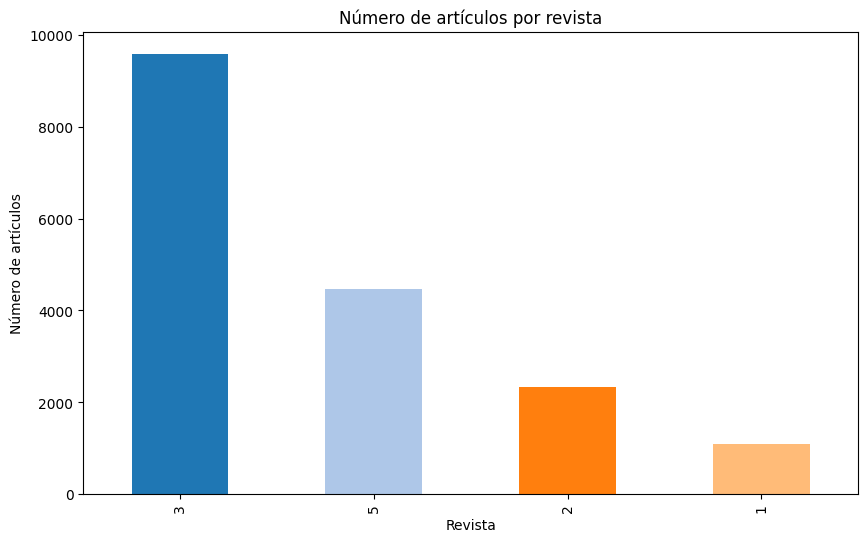

Número de artículos por revista (journal_id):
journal_id
3    9589
5    4465
2    2331
1    1083
Name: count, dtype: int64


In [25]:
## Visualizar número de artículos por revista journal_id con colores múltiples por barra
import matplotlib.pyplot as plt
journal_counts = df['journal_id'].value_counts()
plt.figure(figsize=(10, 6))
journal_counts.plot(kind='bar', color=plt.cm.tab20.colors)
plt.title('Número de artículos por revista')
plt.xlabel('Revista')
plt.ylabel('Número de artículos')
plt.show()

print("Número de artículos por revista (journal_id):")
print(journal_counts)

In [26]:
import pandas as pd
import json
from pathlib import Path

# Definir la ruta base
base_path = Path("../data/raw/1 Applied Ergonomics")

# Años a procesar
years = range(2020, 2025)  # 2020 a 2024 inclusive

# Diccionario para almacenar los resultados
results = {}
total_entries = 0

# Procesar cada archivo
for year in years:
    file_path = base_path / f"Applied_Ergonomics_{year}.json"
    
    if file_path.exists():
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        num_entries = len(data)
        results[year] = num_entries
        total_entries += num_entries
        
        print(f"Applied_Ergonomics_{year}.json: {num_entries} artículos")
    else:
        print(f"⚠️ Archivo no encontrado: {file_path}")
        results[year] = 0

# Resumen
print("\n" + "="*50)
print("RESUMEN:")
print("="*50)
for year, count in results.items():
    print(f"  {year}: {count:4d} artículos")
print("-"*50)
print(f"  TOTAL: {total_entries:4d} artículos")
print("="*50)

# Opcional: Crear un DataFrame con el resumen
summary_df = pd.DataFrame({
    'Año': list(results.keys()),
    'Número de artículos': list(results.values())
})

print("\nDataFrame resumen:")
print(summary_df)

Applied_Ergonomics_2020.json: 232 artículos
Applied_Ergonomics_2021.json: 267 artículos
Applied_Ergonomics_2022.json: 241 artículos
Applied_Ergonomics_2023.json: 183 artículos
Applied_Ergonomics_2024.json: 202 artículos

RESUMEN:
  2020:  232 artículos
  2021:  267 artículos
  2022:  241 artículos
  2023:  183 artículos
  2024:  202 artículos
--------------------------------------------------
  TOTAL: 1125 artículos

DataFrame resumen:
    Año  Número de artículos
0  2020                  232
1  2021                  267
2  2022                  241
3  2023                  183
4  2024                  202
